In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
from math import log2
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import warnings
from minepy import MINE  # Para MIC
from scipy.stats import spearmanr, kendalltau

In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/elias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/elias/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/elias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
warnings.filterwarnings("ignore")


In [ ]:
# Archivo de entrenamiento
df_train = pd.read_csv("tripadvisor_reviews_traducidos_final.csv")
print("Datos de entrenamiento cargados:", df_train.shape)

Datos de entrenamiento cargados: (450, 4)


In [5]:
# Archivo de prueba (sin etiquetas)
df_test = pd.read_csv("tripadvisor_hotel_reviews.csv")
print("Datos de prueba cargados:", df_test.shape)

Datos de prueba cargados: (20491, 2)


In [6]:
# Mostrar estructura
print("\nEjemplo de datos de entrenamiento:")
print(df_train.head())


Ejemplo de datos de entrenamiento:
                                              Review  Rating  traducida  \
0  late night noise cramped rooms overshadow cool...       2       True   
1  cigarette smoke booked hotel reasonably priced...       2       True   
2  better expected clean perfect location helpful...       5       True   
3  great spot clean checked hotel european advent...       4       True   
4  dont stay welcome, stayed 3 nights excellent s...       2       True   

                                           Review_es  
0  Ruido nocturno y habitaciones estrechas opacan...  
1  Reservé este hotel a un precio razonable. Suel...  
2  Mejor de lo esperado: limpio, ubicación perfec...  
3  Gran lugar, limpio. Me hospedé en este hotel d...  
4  No te quedes aquí si quieres sentirte bienveni...  


In [7]:
def classify_by_rating(rating):
    if rating <= 2:
        return "negative"
    else:
        return "positive"

In [8]:
# Aplicar clasificación basada en Rating
df_train['Sentiment'] = df_train['Rating'].apply(classify_by_rating)

In [9]:
# Mostrar distribución de clases
print("\nDistribución de sentimientos basados en Rating (conjunto de entrenamiento):")
print(df_train['Sentiment'].value_counts())


Distribución de sentimientos basados en Rating (conjunto de entrenamiento):
Sentiment
positive    300
negative    150
Name: count, dtype: int64


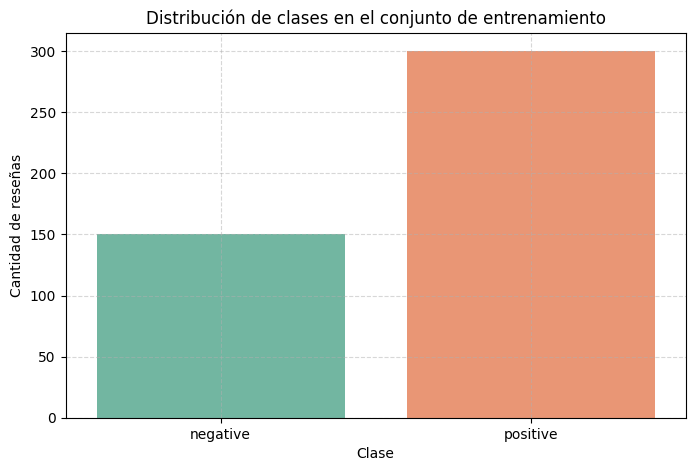

In [10]:
# Graficar distribución de clases
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=df_train, x='Sentiment', palette="Set2")
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xlabel("Clase")
plt.ylabel("Cantidad de reseñas")
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [11]:
def preprocess_text(text, custom_stopwords=None):
    # Convertir a minúsculas
    text = text.lower()
    
    # Tokenización
    tokens = word_tokenize(text)
    
    # Eliminar puntuación
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Lematización
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Eliminar stopwords (incluyendo personalizadas)
    stop_words = set(stopwords.words('english'))
    if custom_stopwords:
        stop_words.update(custom_stopwords)
    tokens = [token for token in tokens if token not in stop_words]
    
    return tokens

In [12]:
custom_stopwords = ["hotel", "room","restaurant","floor","reception"] 

In [13]:
test_review = "The hotel room and restaurant were great but the reception was bad."

tokens = preprocess_text(test_review, custom_stopwords=custom_stopwords)
print(tokens)

['great', 'wa', 'bad']


In [14]:
# Aplicar preprocesamiento a ambos conjuntos
df_train['tokens'] = df_train['Review'].apply(preprocess_text, custom_stopwords=custom_stopwords)
df_test['tokens'] = df_test['Review'].apply(preprocess_text, custom_stopwords=custom_stopwords)

In [15]:
df_train

,Review,Rating,traducida,Review_es,Sentiment,tokens
0,late night noise cramped rooms overshadow cool...,2,True,Ruido nocturno y habitaciones estrechas opacan...,negative,"[late, night, noise, cramped, overshadow, cool..."
1,cigarette smoke booked hotel reasonably priced...,2,True,Reservé este hotel a un precio razonable. Suel...,negative,"[cigarette, smoke, booked, reasonably, priced,..."
2,better expected clean perfect location helpful...,5,True,"Mejor de lo esperado: limpio, ubicación perfec...",positive,"[better, expected, clean, perfect, location, h..."
3,great spot clean checked hotel european advent...,4,True,"Gran lugar, limpio. Me hospedé en este hotel d...",positive,"[great, spot, clean, checked, european, advent..."
4,"dont stay welcome, stayed 3 nights excellent s...",2,True,No te quedes aquí si quieres sentirte bienveni...,negative,"[dont, stay, welcome, stayed, 3, night, excell..."
...,...,...,...,...,...,...
445,lovely honeymoon intimidating.. spending years...,4,True,luna de miel encantadora pero intimidante... p...,positive,"[lovely, honeymoon, intimidating, .., spending..."
446,great location spent nights beachcomber hotel ...,3,True,"""Excelente ubicación, pasamos noches en el hot...",positive,"[great, location, spent, night, beachcomber, e..."
447,disappointed husband stayed hotel weekend main...,2,True,El esposo decepcionado se quedó en el hotel el...,negative,"[disappointed, husband, stayed, weekend, mainl..."
448,"beautiful beach nothing, just got hotel stayed...",2,True,"Playa hermosa, nada más, solo llegamos al hote...",negative,"[beautiful, beach, nothing, got, stayed, 1, 15..."


=== Nube de Palabras - Sentimiento Positivo ===


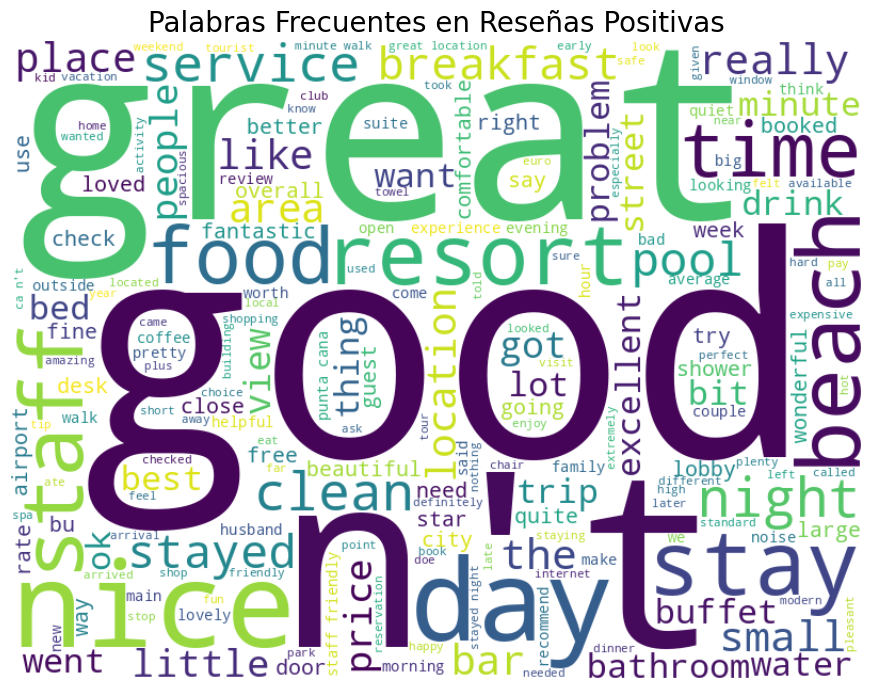

=== Nube de Palabras - Sentimiento Negativo ===


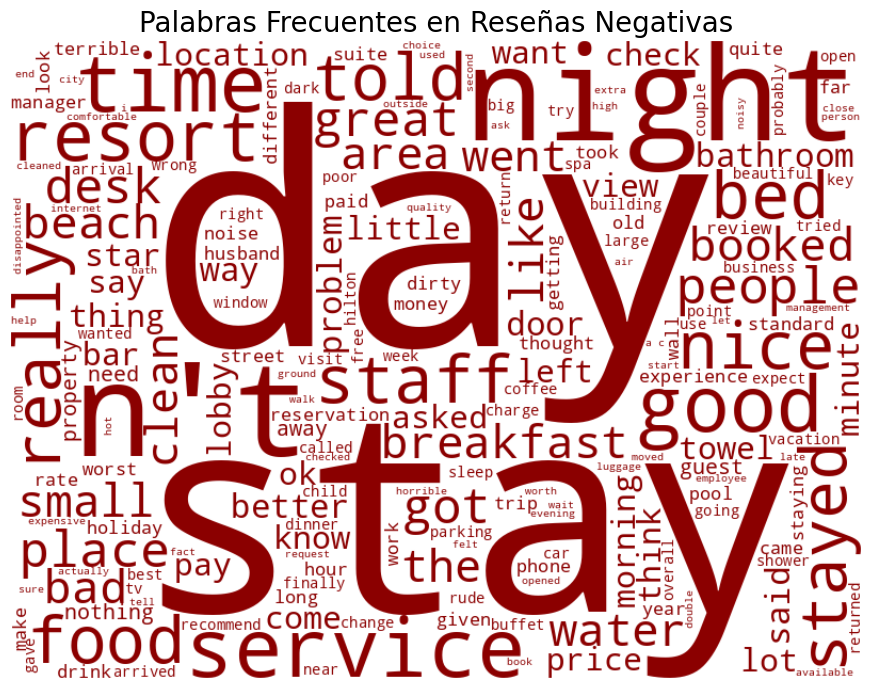

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenar todos los tokens por clase
text_positive = ' '.join(df_train[df_train['Sentiment'] == 'positive']['tokens'].sum())
text_negative = ' '.join(df_train[df_train['Sentiment'] == 'negative']['tokens'].sum())

# Función para generar nube de palabras ---
def generate_wordcloud(text, title=None, color_func=None):
    wordcloud = WordCloud(
        width=800,
        height=600,
        background_color='white',
        stopwords=set(),  # Ya eliminamos stopwords antes
        max_words=200,
        color_func=color_func,
        colormap='viridis'
    ).generate(text)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    if title:
        plt.title(title, fontsize=20)
    plt.tight_layout()
    plt.show()

# Generar y mostrar las nubes ---
print("=== Nube de Palabras - Sentimiento Positivo ===")
generate_wordcloud(text_positive, title="Palabras Frecuentes en Reseñas Positivas")

print("=== Nube de Palabras - Sentimiento Negativo ===")
generate_wordcloud(text_negative, title="Palabras Frecuentes en Reseñas Negativas", color_func=lambda *args, **kwargs: "darkred")

In [ ]:
# Conteo de apariciones por palabra y clase ---
word_counts_positive = defaultdict(int)
word_counts_negative = defaultdict(int)

for _, row in df_train.iterrows():
    words = row['tokens']
    sentiment = row['Sentiment']  # Debe ser 'positive' o 'negative'
    if sentiment == 'positive':
        for word in words:
            word_counts_positive[word] += 1
    else:
        for word in words:
            word_counts_negative[word] += 1

In [ ]:
# Calcular entropía para cada palabra ---
def compute_entropy(word_counts, total_docs):
    entropy = 0.0
    for count in word_counts.values():
        prob = count / total_docs if total_docs > 0 else 0
        if prob > 0:
            entropy -= prob * log2(prob)
    return entropy

total_positive = len(df_train[df_train['Sentiment'] == 'positive'])
total_negative = len(df_train[df_train['Sentiment'] == 'negative'])

entropy_positive = {}
entropy_negative = {}

for word in set(word_counts_positive.keys()).union(set(word_counts_negative.keys())):
    p_pos = word_counts_positive.get(word, 0) / total_positive if total_positive > 0 else 0
    p_neg = word_counts_negative.get(word, 0) / total_negative if total_negative > 0 else 0

    entropy_p = -p_pos * log2(p_pos) if p_pos > 0 else 0
    entropy_n = -p_neg * log2(p_neg) if p_neg > 0 else 0

    entropy_positive[word] = entropy_p
    entropy_negative[word] = entropy_n

In [ ]:
# Selección de palabras clave usando alfa ---
def select_keywords(alpha=2.0):
    positive_keywords = []
    negative_keywords = []

    for word in entropy_positive:
        hp = entropy_positive[word]
        hn = entropy_negative.get(word, float('inf'))
        if hp < hn / alpha:
            positive_keywords.append(word)

    for word in entropy_negative:
        hn = entropy_negative[word]
        hp = entropy_positive.get(word, float('inf'))
        if hn < hp / alpha:
            negative_keywords.append(word)

    return list(set(positive_keywords)), list(set(negative_keywords))

In [ ]:
# Prueba de combinaciones de alfa_p y alfa_n ---
best_alpha_p = None
best_alpha_n = None
best_f1 = 0
best_model = None

In [21]:
# Vectorizar usando presencia/ausencia de palabras clave
def create_feature(review, pos_words, neg_words):
    features = [0, 0]
    tokens = set(review)
    features[0] = sum(1 for word in tokens if word in pos_words)
    features[1] = sum(1 for word in tokens if word in neg_words)
    return features

In [22]:
# Definir rangos de búsqueda para alpha_p y alpha_n
alphas_p = np.arange(1.0, 3.75, 0.25)  # Para palabras positivas
alphas_n = np.arange(1.0, 3.75, 0.25)  # Para palabras negativas

X = []
y = []

for _, row in df_train.iterrows():
    X.append(row['tokens'])
    y.append(1 if row['Sentiment'] == 'positive' else 0)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
# Búsqueda exhaustiva (grid search) sobre combinaciones de alfa_p y alfa_n
for alpha_p in alphas_p:
    for alpha_n in alphas_n:
        print(f"\nProbando combinación: alpha_p={alpha_p:.2f}, alpha_n={alpha_n:.2f}")

        # Seleccionar palabras clave con ambos alfas
        pos_kw, neg_kw = select_keywords(alpha_p), select_keywords(alpha_n)
        pos_kw = pos_kw[0]
        neg_kw = neg_kw[1]

        print(f"Pos keywords: {len(pos_kw)}, Neg keywords: {len(neg_kw)}")

        X_vec = [create_feature(tokens, pos_kw, neg_kw) for tokens in X]
        scores = []

        for train_idx, test_idx in kf.split(X_vec):
            X_train = [X_vec[i] for i in train_idx]
            y_train = [y[i] for i in train_idx]
            X_test = [X_vec[i] for i in test_idx]
            y_test = [y[i] for i in test_idx]

            model = LinearSVC()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            scores.append(f1_score(y_test, y_pred))

        avg_f1 = np.mean(scores)
        print(f"Average F1-score: {avg_f1:.3f}")

        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_alpha_p = alpha_p
            best_alpha_n = alpha_n
            best_model = (pos_kw, neg_kw, model)

print(f"\nMejores alfas encontrados: alpha_p={best_alpha_p:.2f}, alpha_n={best_alpha_n:.2f}")
print(f"Mejor F1-score: {best_f1:.3f}")


Probando combinación: alpha_p=1.00, alpha_n=1.00
Pos keywords: 3692, Neg keywords: 4135
Average F1-score: 0.980

Probando combinación: alpha_p=1.00, alpha_n=1.25
Pos keywords: 3692, Neg keywords: 3974
Average F1-score: 0.988

Probando combinación: alpha_p=1.00, alpha_n=1.50
Pos keywords: 3692, Neg keywords: 3791
Average F1-score: 0.985

Probando combinación: alpha_p=1.00, alpha_n=1.75
Pos keywords: 3692, Neg keywords: 3693
Average F1-score: 0.993

Probando combinación: alpha_p=1.00, alpha_n=2.00
Pos keywords: 3692, Neg keywords: 3662
Average F1-score: 0.993

Probando combinación: alpha_p=1.00, alpha_n=2.25
Pos keywords: 3692, Neg keywords: 3599
Average F1-score: 0.989

Probando combinación: alpha_p=1.00, alpha_n=2.50
Pos keywords: 3692, Neg keywords: 3570
Average F1-score: 0.989

Probando combinación: alpha_p=1.00, alpha_n=2.75
Pos keywords: 3692, Neg keywords: 3545
Average F1-score: 0.991

Probando combinación: alpha_p=1.00, alpha_n=3.00
Pos keywords: 3692, Neg keywords: 3538
Average

In [ ]:
# Entrenamiento del modelo SVM con selección de palabras clave ---

def select_keywords_by_entropy(alpha_p=2.0, alpha_n=3.75):
    positive_keywords = []
    negative_keywords = []

    for word in entropy_positive:
        hp = entropy_positive[word]
        hn = entropy_negative.get(word, float('inf'))
        if hp < hn / alpha_p:
            positive_keywords.append(word)

    for word in entropy_negative:
        hn = entropy_negative[word]
        hp = entropy_positive.get(word, float('inf'))
        if hn < hp / alpha_n:
            negative_keywords.append(word)

    return list(set(positive_keywords)), list(set(negative_keywords))

In [25]:
# Seleccionar mejores palabras clave según alphas del artículo
alpha_p_opt = best_alpha_p
alpha_n_opt = best_alpha_n
pos_keywords, neg_keywords = select_keywords_by_entropy(alpha_p_opt, alpha_n_opt)

print(f"\nPalabras clave positivas ({len(pos_keywords)}): {pos_keywords[:10]}...")
print(f"Palabras clave negativas ({len(neg_keywords)}): {neg_keywords[:10]}...")


Palabras clave positivas (2629): ['shell', 'mauro', 'treatment', 'stiffed', '11pm', 'wetroom', 'conditioning', 'emma', '4/5', 'hotel:1.']...
Palabras clave negativas (3791): ['stronger', 'call.maybe', 'expedious', 'impeccably', 'pickiest', 'jolly', 'peahen', 'trick', 'heating/air', 'heated.there']...


In [26]:
# Vectorizar todas las reseñas usando presencia/ausencia de palabras clave
def create_feature(review_tokens, pos_words, neg_words):
    tokens_set = set(review_tokens)
    return [
        sum(1 for w in tokens_set if w in pos_words),
        sum(1 for w in tokens_set if w in neg_words)
    ]

X_train = [create_feature(tokens, pos_keywords, neg_keywords) for tokens in df_train['tokens']]
y_train = [1 if s == 'positive' else 0 for s in df_train['Sentiment']]

In [28]:
from sklearn.model_selection import cross_val_score
# Entrenar modelo SVM
model = LinearSVC(C=0.5)
model.fit(X_train, y_train)

# Validación cruzada para medir rendimiento
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1')
print(f"\nRendimiento del modelo (F1-score promedio): {np.mean(cv_scores):.2f}")


Rendimiento del modelo (F1-score promedio): 1.00


In [ ]:
# Clasificar todas las reseñas del conjunto de prueba ---
df_test['features'] = df_test['tokens'].apply(
    lambda t: create_feature(t, pos_keywords, neg_keywords)
)
X_test = np.array(df_test['features'].tolist())
df_test['predicted_sentiment'] = model.predict(X_test)
df_test['sentiment_label'] = df_test['predicted_sentiment'].map({0: 'negative', 1: 'positive'})


In [ ]:
# Calcular proporción de sentimientos por reseña ---
df_test['positive_ratio'] = df_test['sentiment_label'].apply(lambda x: 1 if x == 'positive' else 0).rolling(window=100, min_periods=1).mean()
df_test['negative_ratio'] = df_test['sentiment_label'].apply(lambda x: 1 if x == 'negative' else 0).rolling(window=100, min_periods=1).mean()

if 'Rating' not in df_test.columns:
    raise ValueError("La columna 'Rating' no está presente en el conjunto de prueba.")
ratings = df_test['Rating'].values

positive_ratios = df_test['positive_ratio'].fillna(0).values
negative_ratios = df_test['negative_ratio'].fillna(0).values

In [31]:
# --- 11. Análisis de correlación ---
from scipy.stats import spearmanr, kendalltau
from minepy import MINE

# Spearman
s_rho_pos, s_p_pos = spearmanr(positive_ratios, ratings)
s_rho_neg, s_p_neg = spearmanr(negative_ratios, ratings)

# Kendall
k_tau_pos, k_p_pos = kendalltau(positive_ratios, ratings)
k_tau_neg, k_p_neg = kendalltau(negative_ratios, ratings)

# MIC
mine = MINE()

mine.compute_score(positive_ratios, ratings)
mic_pos = mine.mic()

mine.compute_score(negative_ratios, ratings)
mic_neg = mine.mic()

In [32]:
# --- 12. Mostrar resultados ---
print("\n=== Correlación entre Positive Ratio y Rating ===")
print(f"Spearman's ρ: {s_rho_pos:.3f} (p={s_p_pos:.4f})")
print(f"Kendall's τ: {k_tau_pos:.3f} (p={k_p_pos:.4f})")
print(f"Mic: {mic_pos:.3f}")

print("\n=== Correlación entre Negative Ratio y Rating ===")
print(f"Spearman's ρ: {s_rho_neg:.3f} (p={s_p_neg:.4f})")
print(f"Kendall's τ: {k_tau_neg:.3f} (p={k_p_neg:.4f})")
print(f"Mic: {mic_neg:.3f}")


=== Correlación entre Positive Ratio y Rating ===
Spearman's ρ: 0.162 (p=0.0000)
Kendall's τ: 0.125 (p=0.0000)
Mic: 0.021

=== Correlación entre Negative Ratio y Rating ===
Spearman's ρ: -0.162 (p=0.0000)
Kendall's τ: -0.125 (p=0.0000)
Mic: 0.021
